# **基于u-net的高压线路检测——使用飞桨平台进行训练分析**

# 1. 项目简介

	本项目介绍利用u-net结构搭建的一个图像分割任务。通过自建数据集，并使用基于Paddle的方法完成图像分割任务。
<img src="https://img1.baidu.com/it/u=3167543494,2570365749&fm=253&fmt=auto&app=120&f=JPEG?w=1200&h=678" width="500">
  <p style="margin-top: 20px">              图1 百度飞桨平台</p>
</div>

## 1.1 选择高压线路检测的原因意义
	我国高压输电线路距离长，沿线所处环境复杂，易使得输电线路受到严重的锈蚀破坏。由于输电线路中环境背景过于复杂，但凭借人眼观察难以做到完全识别。通过计算机视觉的方法可以帮助提高检测速度，提升检测精度。
    
## 1.2 高压线路检测的环境情况展示
<img src="https://img1.baidu.com/it/u=3384365198,1642888984&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=329" width="500">
  <p style="margin-top: 20px">              图2 高压直流输电线路</p>
</div>

<img src="https://img1.baidu.com/it/u=3064826551,682075486&fm=253&fmt=auto&app=138&f=JPEG?w=640&h=427" width="500">
  <p style="margin-top: 20px">              图3 高压电线</p>
</div>

## 1.3项目拟使用的方法
	拟采用paddle套件实现一个线路检测。检测模型采用U-net模型。

<img src="https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fimg-blog.csdnimg.cn%2F20200110190832180.png%3Fx-oss-process%3Dimage%2Fwatermark%2Ctype_ZmFuZ3poZW5naGVpdGk%2Cshadow_10%2Ctext_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhdGZpc2hI%2Csize_16%2Ccolor_FFFFFF%2Ct_70&refer=http%3A%2F%2Fimg-blog.csdnimg.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1649245165&t=7cb1caa1716fd1d435c136a46454b0d6" width="700">
  <p style="margin-top: 20px">              图4 U-net网络结构</p>
</div>
    

# 2. 数据集来源
本项目采用毕业指导老师给予数据集。

# 3. U-net网络
下面以U-Net网络为例，进行训练、验证和预测的方法。
详情如下
## 3.1 U-Net网络粗略介绍

U-Net是比较早的使用全卷积网络进行语义分割的算法之一，论文中使用包含压缩路径和扩展路径的对称U形结构在当时非常具有创新性，且一定程度上影响了后面若干个分割网络的设计，该网络的名字也是取自其U形形状。

U-Net的实验是一个比较简单的ISBI cell tracking数据集，由于本身的任务比较简单，U-Net紧紧通过30张图片并辅以数据扩充策略便达到非常低的错误率，拿了当届比赛的冠军。
## 3.2 U-Net网络的优势与不足
每个蓝色框对应一个多通道特征图，其中通道数在框顶标。x-y的大小位于框的左下角。灰色框表示复制和裁剪（Concat）的特征图。箭头表示不同的操作。
该网络由收缩路径（contracting path）和扩张路径（expanding path）组成。其中，收缩路径用于获取上下文信息（context），扩张路径用于精确的定位（localization），且两条路径相互对称。U-Net网络能从极少的训练图像中，依靠数据增强将有效的标注数据更为有效地使用。
U-Net与其他常见的分割网络（如FCN）有一点非常不同的地方：
    1.U-net采用了完全不同的特征融合方式：拼接（Concat），U-Net采用将特征在channel维度拼接在一起，形成更厚的特征。而FCN融合时使用的对应点相加，并不形成更厚的特征。
所以语义分割网络在特征融合时有两种办法：
    2.FCN式的对应点相加。U-Net式的channel维度拼接融合。
除了上述新颖的特征融合方式，U-Net还有以下几个优点：
    1.5个pooling layer实现了网络对图像特征的多尺度特征识别。上采样部分会融合特征提取部分的输出，这样做实际上是将多尺度特征融合在了一起，以最后一个上采样为例，它的特征既来自第一个卷积block的输出(同尺度特征)，也来自上采样的输出(大尺度特征)，这样的连接是贯穿整个网络的，你可以看到上图的网络中有四次融合过程，相对应的FCN网络只在最后一层进行融合。
U-Net也有两点明显的不足：
    1.该网络运行效率很慢。对于每个邻域，网络都要运行一次，且对于邻域重叠部分，网络会进行重复运算。网络需要在精确的定位和获取上下文信息之间进行权衡。越大的patch需要越多的最大池化层，其会降低定位的精确度，而小的邻域使得网络获取较少的上下文信息。
	 2.该网络没有全连接层，且仅使用每个卷积的有效部分，例如：分割图仅包含在输入图像中可获得完整上下文信息的像素。该策略允许通过重叠-切片（overlap-tile）策略对任意大的图像进行无缝分割。

# 4. 模型介绍
## 4.1 解压数据集


In [1]:
! unzip /home/aistudio/data/data131233/line.zip

## 4.2 环境设置

导入一些比较基础常用的模块，确认自己的飞桨版本。


In [3]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage

import paddle
from paddle.nn import functional as F

paddle.set_device('gpu')
paddle.__version__

## 4.3原始数据初步处理——采用图像二值化处理
	如果直接将格式转换后的格式送入模型，会发现最多有256个标签，这是因为单通道的标注图片，图片最多有255种像素，每一种像素值代表一种类别，像素标注类别需要从0开始递增，例如0，1，2，3表示有4种类别，所以标注类别最多为256类。但其实我们只需要找到电线的位置，因此划分出的电线就作为一个类，其背景作为另一个类别，这样总共有2个类别。下面来看一下如何使用opencv做图像二值化处理。


In [4]:
import cv2
import matplotlib.pyplot as plt

#循环灰度图片并保存
def grayImg():
    for x in range(5356,6070):#图片名称从5356开始到6069 ()左闭右开
        #读取图片
        img = cv2.imread("line/Annotations/{}.png".format(str(x))) 
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #转换为灰度图
        ##灰度极差的一半作为阙值
        difference = (img_gray.max() - img_gray.min()) // 2
        _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
        ##图像二极化
        # print("阈值：", _)
        #保存灰度后的新图片
        cv2.imwrite("line/chuliann/{}.png".format(str(x)), img_binary)
    plt.imshow(img_binary)
    plt.show()
grayImg()

## 4.4生成训练的输入数据与标签数据的对比
获得样本总个数，划分训练集测试集的数量比为8：2

In [6]:
IMAGE_SIZE = (160, 160)
train_images_path = "line/JPEGImages" ##
label_images_path = "line/chuliann" ##
image_count = len([os.path.join(train_images_path, image_name) for image_name in os.listdir(train_images_path) if image_name.endswith('.bmp')])
print("用于训练集的图片样本数量:", image_count)
def _sort_images(image_dir, image_type):
    """
    对文件夹内的图像进行按照文件名排序
    """
    files = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.{}'.format(image_type))  and not image_name.startswith('.'):
            files.append(os.path.join(image_dir, image_name))

    return sorted(files)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))
    
"""
由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，
所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
在这里是用了一个非常简单的方法，按照文件名称进行排序。
因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。
"""
images = _sort_images(train_images_path, 'bmp')
labels = _sort_images(label_images_path, 'png')
eval_num = int(image_count * 0.20)

write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('predict', images[-eval_num:], labels[-eval_num:])

数据的可视化展示


## 4.5样本的可视化展示
划分好数据集之后，我们来查验一下数据集是否符合预期，我们通过划分的配置文件读取图片路径后再加载图片数据来用matplotlib进行展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

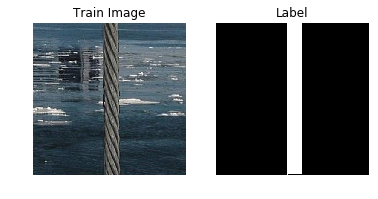

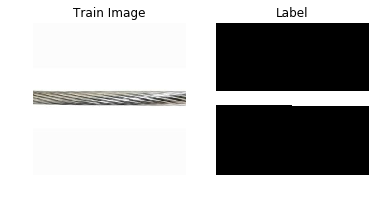

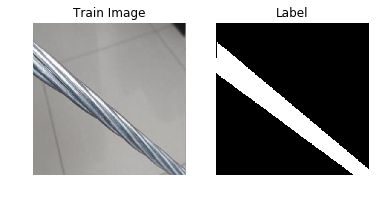

In [16]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t') ##\t表示输出空格  split表示分割  strip() 方法用于移除字符串头尾指定的字符
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))
    
        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

## 4.6数据集的定义
数据集类的定义（继承paddle.io.Dataset的类）
paddle.io.Dataset，并实现父类中以下两个抽象方法，__getitem__和__len__。
	并在在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。使图片格式保持一致。

In [8]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T


class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)
print('运行完毕，已定义')

## 4..7设置unet模型结构
先定义两层卷积，利用两层卷积与最大池化层向前传递计算，按照顺序组成unet网络结构

In [9]:
import paddle
import paddle.nn as nn

class DoubleConv(nn.Layer):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2D(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2D(out_ch),
            nn.ReLU(),
            nn.Conv2D(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2D(out_ch),
            nn.ReLU()
        )

    def forward(self, input):
        return self.conv(input)


class myUnet(nn.Layer):
    def __init__(self,num_classes):
        super(myUnet, self).__init__()

        self.conv1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2D(2,2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2D(2,2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2D(2,2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2D(2,2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.Conv2DTranspose(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.Conv2DTranspose(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.Conv2DTranspose(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.Conv2DTranspose(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2D(64, num_classes, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = paddle.concat([up_6, c4], axis=1)##paddle.concat 将两层数据结合
        c6=self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = paddle.concat([up_7, c3], axis=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = paddle.concat([up_8, c2], axis=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = paddle.concat([up_9, c1], axis=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        return c10

## 4.8unet模型结构的可视化

In [18]:
num_classes = 2
network=myUnet(2)
paddle.summary(network,(10,3,32,32))
x = paddle.randn((10, 3, 32, 32))
# 测试模型前向计算
y = network(x)
# 打印输出维度
print(y.shape)

-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-20      [[10, 3, 32, 32]]     [10, 64, 32, 32]        1,792     
 BatchNorm2D-19    [[10, 64, 32, 32]]    [10, 64, 32, 32]         256      
     ReLU-19       [[10, 64, 32, 32]]    [10, 64, 32, 32]          0       
    Conv2D-21      [[10, 64, 32, 32]]    [10, 64, 32, 32]       36,928     
 BatchNorm2D-20    [[10, 64, 32, 32]]    [10, 64, 32, 32]         256      
     ReLU-20       [[10, 64, 32, 32]]    [10, 64, 32, 32]          0       
  DoubleConv-10    [[10, 3, 32, 32]]     [10, 64, 32, 32]          0       
   MaxPool2D-5     [[10, 64, 32, 32]]    [10, 64, 16, 16]          0       
    Conv2D-22      [[10, 64, 16, 16]]   [10, 128, 16, 16]       73,856     
 BatchNorm2D-21   [[10, 128, 16, 16]]   [10, 128, 16, 16]         512      
     ReLU-21      [[10, 128, 16, 16]]   [10, 128, 16, 16]          0       
    Conv2D

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


## 4.9设置训练参数

In [11]:
model = paddle.Model(network)
train_dataset = PetDataset(mode='train') # 训练数据集

val_dataset = PetDataset(mode='test') # 验证数据集

optim = paddle.optimizer.RMSProp(learning_rate=0.001,    
                                 rho=0.9, 
                                 momentum=0.0, 
                                 epsilon=1e-07, 
                                 centered=False,
                                 parameters=model.parameters())
model.prepare(optim, paddle.nn.CrossEntropyLoss(axis=1))
model.fit(train_dataset, 
          val_dataset, 
          epochs=15, 
          batch_size=32,
          verbose=1)

#  5训练结果预测
## 5.1使用PetDataset来实例化待预测使用的数据集。这里我们为了方便没有在另外准备预测数据，复用了评估数据。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [20]:

predict_dataset = PetDataset(mode='predict')
predict_results = model.predict(predict_dataset)

Predict begin...
step 142/142 [==============================] - 10ms/step         
Predict samples: 142


## 5.2预测结果可视化
从我们的预测数据集中抽3个图片来看看预测的效果，展示一下原图、标签图和预测结果。

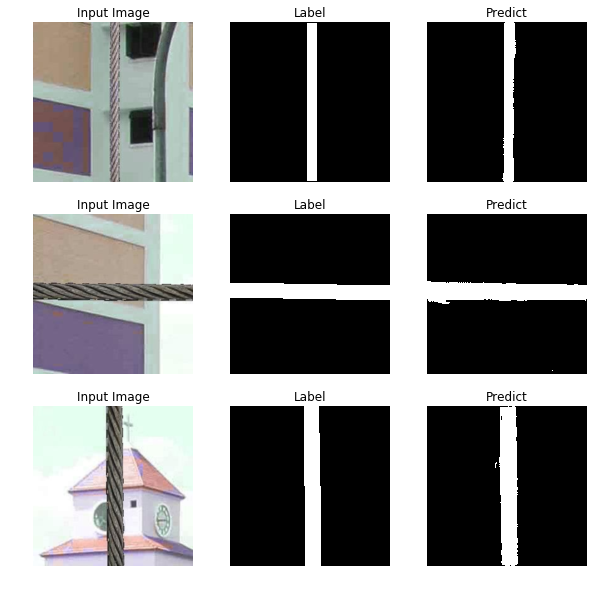

In [23]:
plt.figure(figsize=(10, 10))

i = 0
mask_idx = 0

with open('./predict.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(PilImage.open(image_path))
        label = resize_t(PilImage.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')

        if i > 8: 
            break
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis("off")

        plt.subplot(3, 3, i + 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis("off")
        
        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        data = predict_results[0][mask_idx][0].transpose((1, 2, 0))
        mask = np.argmax(data, axis=-1)

        plt.subplot(3, 3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        i += 3
        mask_idx += 1

plt.show()

# 6. 项目总结
#   首先是，个人代码相关知识储备不足，学习过于仓促，较大部分代码观察苦难，理解尚有难度。代码部分借鉴了** [跟着雨哥学AI』系列06：趣味案例——基于U-Net的宠物图像分割](https://aistudio.baidu.com/aistudio/projectdetail/1246330)，以及[基于PaddleSeg的眼底血管分割](https://aistudio.baidu.com/aistudio/projectdetail/1144243?channelType=0&channel=0)**，感谢二位作者。
#   然后是，从结果预测图像上看，预测图明显与标签图仍具有少量差距，明显可以看出有边缘初有少量毛刺。此处问题仍待后续的分析，尝试经过后续的相关更深层次的学习，进一步深化调试模型，进一步降低损失率，提高精确度，将此问题解决。
  最后是，作者个人介绍：郑州大学本科生，因毕业设计需要认识到百度飞桨平台，寄期以此提高自己。
  作者个人主页：[俩月仍](https://aistudio.baidu.com/aistudio/usercenter)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 